In [18]:
import gym
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make('CartPole-v1')
env.reset()


array([-0.02257066, -0.04712394, -0.04959457, -0.01279513])

In [19]:
action_space = env.action_space.n
print(f"There are {action_space} possible actions.")


There are 2 possible actions.


In [20]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from collections import deque
import numpy as np

In [21]:
class Memory():
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        index = np.random.choice(np.arange(buffer_size),
                                 size=batch_size,
                                 replace=False)
        return [self.buffer[i] for i in index]

In [22]:
mem = Memory(10)
[mem.add(i) for i in np.arange(10)]
mem.sample(5)

[0, 8, 5, 1, 3]

In [23]:
MEMORY_SIZE = 600
pretrain_length = 10
memory = Memory(max_size=MEMORY_SIZE)

state = env.reset() #env.decode(env.reset()))

done = False
step_limit = 600
step = 0
while step < step_limit:
    
    random_action = env.action_space.sample()
    new_state, reward, done, info = env.step(random_action)
    
    
    memory.add((state, random_action, new_state, reward, done, info))
    
    if done:
        state = env.reset() 
        
    else:
        state = new_state
        
    step += 1


In [24]:
memory.sample(3)


[(array([-0.04995308,  0.34708712,  0.02379961, -0.45910456]),
  1,
  array([-0.04301134,  0.5418647 ,  0.01461752, -0.74419176]),
  1.0,
  False,
  {}),
 (array([ 0.01873945,  0.79360303,  0.08274351, -0.70245909]),
  1,
  array([ 0.03461151,  0.98748661,  0.06869433, -0.96799062]),
  1.0,
  False,
  {}),
 (array([ 0.00526792, -0.62564526, -0.01350803,  0.7952413 ]),
  0,
  array([-0.00724499, -0.82057924,  0.0023968 ,  1.08364436]),
  1.0,
  False,
  {})]

In [25]:
# predict the Q value of each action given the state
inputs = layers.Input(shape=(4,))
x = layers.Dense(50, activation="relu")(inputs)
x = layers.Dense(50, activation="relu")(x)
outputs = layers.Dense(2, activation="linear")(x)

model = tf.keras.Model(inputs, outputs)
model_target = tf.keras.Model(inputs, outputs)


model.output_shape
model(tf.random.uniform((3,4),-1,1))

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[-0.03683413, -0.0183279 ],
       [-0.20276211, -0.2177669 ],
       [ 0.04845861, -0.1822306 ]], dtype=float32)>

In [26]:
def select_action(episode, model, state, min_epsilon, max_epsilon, decay_rate):

    # random number for explore/exploit trade-off
    epsilon = np.random.rand()

    # current ee prob
    explore_prob = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*episode)

    if epsilon < explore_prob:
        action = env.action_space.sample()
    else:
        q_vals = model(tf.expand_dims(state, axis=0))
        action = np.argmax(q_vals)

    return action


In [27]:
state = env.reset()
[select_action(1, model, tf.random.normal((4,)), 0.0, 0.0, 0.01) for i in range(10)]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 0]

In [28]:
def get_minibatch(model, memory, gamma, batch_size):

    # memory structure: (state, action, new_state, reward, done, info)

    batch = memory.sample(batch_size)
    states = np.array([each[0] for each in batch])
    actions =[each[1] for each in batch]
    next_states = np.array([each[2] for each in batch])
    rewards = [each[3] for each in batch]
    dones = tf.constant([each[4] for each in batch], dtype=tf.float32)

    # get q values from target model
    q_target = model(next_states)
    
    q_target = tf.reduce_max(q_target, axis=1)
    # set done q_target = reward and discount the others
    q_target = rewards + gamma * (1. - dones) * q_target

    return q_target, states, actions

get_minibatch(model, memory, 0.99, 3)

(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.9613245 , 0.84012526, 0.8266217 ], dtype=float32)>,
 array([[ 2.70633112e-02,  4.08537777e-02,  7.50476390e-05,
          2.91429823e-02],
        [ 1.76725186e-02, -5.73411478e-01, -9.76108902e-03,
          7.57096472e-01],
        [-9.16366193e-03, -5.73347427e-01,  2.63146790e-02,
          7.55702943e-01]]),
 [0, 0, 0])

In [29]:
total_episodes = 10000       # Total number of training episodes
max_steps = 200               # Max steps per episode
batch_size = 64

learning_rate = 0.01          # Learning rate
gamma = 0.9                  # Discounting rate

# Exploration parameters
epsilon = 1.0               # Exploration rate
max_epsilon = 1             # Exploration probability at start
min_epsilon = .1            # Minimum exploration probability 
decay_rate = 0.003          # Exponential decay rate for exploration prob

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

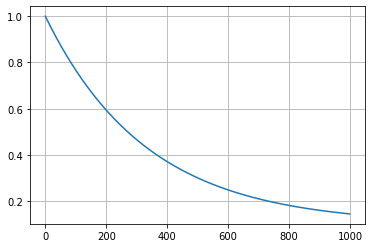

In [30]:
def explore(min_epsilon, max_epsilon, decay_rate, episode):
    return min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*episode)
    

plt.plot(np.arange(1000), [explore(min_epsilon, max_epsilon, decay_rate, e) for e in np.arange(1000)])
plt.grid()
plt.show()

In [31]:
episode_reward_hist = []
episode_loss_hist = []

for episode in range(total_episodes):

    step = 0
    state = env.reset() #list(env.decode(env.reset()))
    done = False
    episode_reward = 0

    # play and record in memory
    while not done:
        step += 1
        action = select_action(episode, model, state, min_epsilon, max_epsilon, decay_rate)
        new_state, reward, done, info = env.step(action)
        
        memory.add((state, action, new_state, reward, done, info))
                
        
        if done:
            state = env.reset() #list(env.decode(env.reset()))
        else:
            state = new_state
        episode_reward += reward

    episode_reward_hist.append(episode_reward)
    
    # sample from memory and train
    q_target, states, actions = get_minibatch(model_target, memory, gamma, batch_size)

    with tf.GradientTape() as tape:
        
        q_values = model(states)
        
        masks = tf.one_hot(actions, env.action_space.n)
        
        q_action = tf.reduce_max(tf.multiply(q_values, masks), axis=1)

        loss = tf.keras.losses.MeanSquaredError()(q_target, q_action)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    episode_loss_hist.append(loss)

    if episode % 50 == 0:
        model_target.set_weights(model.get_weights())

    if episode % 100 ==0:
        print(f"Episode: {episode}\tLoss: {loss:.3f}\tEpisode reward: {episode_reward}")


Episode: 0	Loss: 0.862	Episode reward: 36.0
Episode: 100	Loss: 3.630	Episode reward: 14.0
Episode: 200	Loss: 1.495	Episode reward: 26.0
Episode: 300	Loss: 0.930	Episode reward: 78.0
Episode: 400	Loss: 0.515	Episode reward: 28.0
Episode: 500	Loss: 0.091	Episode reward: 126.0
Episode: 600	Loss: 0.452	Episode reward: 182.0
Episode: 700	Loss: 0.016	Episode reward: 293.0
Episode: 800	Loss: 0.014	Episode reward: 357.0
Episode: 900	Loss: 0.470	Episode reward: 192.0
Episode: 1000	Loss: 0.020	Episode reward: 208.0
Episode: 1100	Loss: 0.686	Episode reward: 282.0
Episode: 1200	Loss: 0.006	Episode reward: 474.0


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.plot(episode_reward_hist)
plt.grid()
plt.subplot(2,1,2)
plt.plot(episode_loss_hist)
plt.grid()
plt.show()


In [ ]:
from matplotlib import animation , rc
%matplotlib inline

fig = plt.figure()

frame = []
env.reset()

for episode in range(1):

    step = 0
    state = env.reset() #list(env.decode(env.reset()))
    done = False
    episode_reward = 0


    # play and record in memory

    while not done:
        step += 1
        action = select_action(episode, model, state, 0, 0, decay_rate)

        new_state, reward, done, info = env.step(action)
        img = plt.imshow(env.render('rgb_array'))
        frame.append([img])
        
        if done:
            state = env.reset() 
        else:
            state = new_state
        episode_reward += reward

    print(f"episode lasted {step} steps")
an = animation.ArtistAnimation(fig, frame, interval=100, repeat_delay=1000, blit=True)
rc('animation', html='jshtml')
an